This notebook produces the following figures that are used in the manuscript:

1. Visual convergence of the solution of $\text{KdVH}(\tau)$ to the KdV solution using a time-stepping method.
2. Traveling Waves Using the Petviashvili Method.
3. Quantitative comparison of the asymptotic-preserving (AP) property by different time-stepping methods.
4. Asymptotic Accuracy Plots.
5. Error growth plots for different methods, with and without RK relaxation, applied to $\text{KdVH}(\tau)$, with the exact solution computed using the Petviashvili method.
6. RK relaxation on $\text{KdVH}(\tau)$ to verify linear and quadratic error convergence using conservative versus non-conservative methods.

In [ ]:
include("code.jl")

  Activating project at `~/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/2024_kdvh_RR`


plot_kdvh_traveling_approximation (generic function with 1 method)

### Visual convergence of the solution of $\text{KdVH}(\tau)$ to the KdV solution.

  0.183508 seconds (32.30 k allocations: 1.448 MiB)
  0.326325 seconds (36.45 k allocations: 6.559 MiB)
  0.330413 seconds (36.45 k allocations: 6.559 MiB)
  0.332413 seconds (36.45 k allocations: 6.559 MiB)


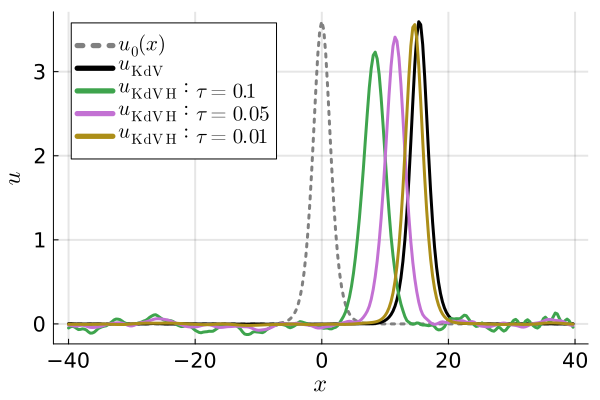

In [ ]:
domain_traversals = 1.2; # This will determien the final time = domain_traversals*(xmax-xmin)/c
accuracy_order = 1; N = 2^8;
alg = ARS443(); dt = 0.01;
τs = [1.0e-1, 5.0e-2, 1.0e-2]

# Initialization of physical and numerical parameters
(; xmin, xmax, c) = solitary_wave_setup()
tspan = (0.0, domain_traversals * (xmax - xmin) / c)

D1 = upwind_operators(periodic_derivative_operator;
                      derivative_order = 1, accuracy_order,
                      xmin, xmax, N)


# Setup plot
fig_KdVH_KdV = plot(; xguide = L"x", yguide = L"u", plot_kwargs()...)

# KdV
let equation = KdV()
    (; q0, parameters) = setup(solitary_wave_solution, equation,
                               tspan, D1)
    @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                            rhs_nonstiff!,
                            q0, tspan, parameters, alg;
                            dt)

    x = grid(parameters.D1)
    plot!(fig_KdVH_KdV, x, get_u(sol.u[begin], equation);
          label = L"u_0(x)", linestyle=:dot, color=:grey, plot_kwargs()...)
    plot!(fig_KdVH_KdV, x, get_u(sol.u[end], equation);
          label = L"u_\mathrm{KdV}", color=:black, plot_kwargs()...)
end

# Assuming `τs` is an array of different values of τ
line_styles = [:solid, :dash, :dot, :dashdot]  # Define some line styles

for (i, τ) in enumerate(τs)
    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt)

        x = grid(parameters.D1)
        # Use label with τ and different line styles
        #plot!(fig_KdVH_KdV, x, get_u(sol.u[end], equation);
        #      label = "KdVH($τ)", title = "Comparison of KdVH and KdV", linestyle = line_styles[i % length(line_styles) + 1], plot_kwargs()...)
        plot!(fig_KdVH_KdV, x, get_u(sol.u[end], equation);
              label = L" u_\mathrm{KdVH}:"*"\$τ = $(τ)\$", plot_kwargs()...)
    end
end

plot!(fig_KdVH_KdV; legend = :topleft)

In [3]:
# To handle paths and directories, install the following package
# Pkg.add("FilePathsBase")

In [4]:
using FilePathsBase

# Define paths
save_path_1 = joinpath("..", "img")
save_path_2 = joinpath("..", "tables_data")

# Create directories if they do not exist
if !isdir(save_path_1)
    mkdir(save_path_1)
end

if !isdir(save_path_2)
    mkdir(save_path_2)
end

In [54]:
savefig(fig_KdVH_KdV, joinpath(save_path_1, "KdVH_convergence_KdV_ARS443.pdf"))

"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/KdVH_convergence_KdV_ARS443.pdf"

### Traveling Waves Using the Petviashvili Method.

In [6]:
using LinearAlgebra: LinearAlgebra, I, norm

In [7]:
# Exact solution for the traveling wave solution for the KdV
function kdv_solution(ξ, c)
    A = 3 * c
    K = sqrt(3 * A) / 6

    return A / cosh(K * ξ)^2
end

kdv_solution (generic function with 1 method)

In [ ]:
function petviashvili_kdv(; xmin = - 40.0, xmax = 40.0, c = 1/3, N = 2^8, maxiter = 1000, tol = 1.0e-14)

    D = fourier_derivative_operator(xmin, xmax, N)

    L = c * I - D^2
    N_fun(u) = 0.5 .* u.^2
    γ = 2
    # Initialization
    x = grid(D)
    u0 = exp.(-x.^2)
    # Iteration
    u = copy(u0)
    for iter in 1:maxiter
        res = norm(L * u - N_fun(u), Inf)
        #println(res)
        if res < tol
            @info "Converged" iter res
            break
        end
        m = integrate(u .* (L * u), D) / integrate(u .* N_fun(u), D)
        u = m^γ * (L \ N_fun(u))
    end
    # Visualization
    #fig = plot(x, u0; label = L"u_0", xguide = L"x", yguide = L"u", linewidth = 2)
    #plot!(fig, x, u; label = L"u_\mathrm{num}", linewidth = 2)
    #u_ana = kdv_solution.(x, c)
    #@info "Error wrt KdV solution" norm(u - u_ana, Inf)
    #plot!(fig, x, u_ana; label = L"u_{\mathrm{ana}}", linewidth = 2, linestyle = :dot)
    return (; x, u)
end

petviashvili_kdv (generic function with 1 method)

In [ ]:
function petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = 100, c = 1/3, N = 2^8, maxiter = 1000, tol = 1.0e-14)
    # Setup numerical discretization with periodic boundary conditions

    D = fourier_derivative_operator(xmin, xmax, N)
    D1 = Matrix(D);
    L = (λ^2*c/((λ+c)*(λ-c^2))) .* I - D^2

    N_fun(u) = (λ^2/((λ+c)*(λ-c^2))) .*0.5 .* u.^2 + (c/(λ-c^2)) .* D1 * (u .* (D1 * u))
    γ = 2
    # Initialization
    x = grid(D)
    u0 = exp.(-x.^2)

    # Iteration
    u = copy(u0)
    for iter in 1:maxiter
        res = norm(L * u - N_fun(u), Inf)
        #println(res)
        if res < tol
            @info "Converged" iter=iter res=res
            break
        end
        m = integrate(u .* (L * u), D) / integrate(u .* N_fun(u), D)
        u = m^γ * (L \ N_fun(u))
    end
    return (; x, u)
end

petviashvili_kdvh (generic function with 1 method)

#### Plot

┌ Info: Converged
│   iter = 62
└   res = 6.966649479522857e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdv - u_ana, Inf) = 3.736445463143145e-10
┌ Info: Converged
│   iter = 54
└   res = 7.668487006787357e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_1 - u_ana, Inf) = 0.143596533919097
┌ Info: Converged
│   iter = 58
└   res = 9.159339953157541e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_2 - u_ana, Inf) = 0.07589301216250632
┌ Info: Converged
│   iter = 61
└   res = 8.548717289613705e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_3 - u_ana, Inf) = 0.01593598115019218


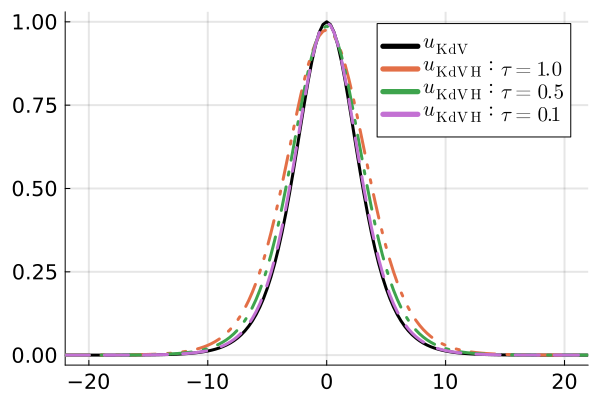

In [51]:
c = 1/3;
x, u_kdv = petviashvili_kdv(; xmin = - 40.0, xmax = 40.0, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
u_ana = kdv_solution.(x, c)

@info "Error wrt KdV solution" norm(u_kdv - u_ana, Inf)

τ1 = 1.0e-0; λ1 = 1/τ1;
x, u_kdvh_1 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ1, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_1 - u_ana, Inf)

τ2 = 5.0e-1; λ2 = 1/τ2;
x, u_kdvh_2 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ2, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_2 - u_ana, Inf)

τ3 = 1.0e-1; λ3 = 1/τ3;
x, u_kdvh_3 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ3, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_3 - u_ana, Inf)

# Visualization
xL = -7*π; xR = 7*π
fig_sol_wave = plot(x, u_ana; color = :black,label = L"u_\mathrm{KdV}", linestyle=:solid, xlims=(xL, xR),plot_kwargs()...)
#plot!(fig_sol_wave, x, u_kdv; label = L"u_\mathrm{KdV}", xguide = L"x", yguide = L"u",linestyle=:dot, xlims=(xL, xR),plot_kwargs()...)
plot!(fig_sol_wave, x, u_kdvh_1; label = L" u_\mathrm{KdVH}:"*"\$τ = $(τ1)\$",linestyle=:dashdotdot, xlims=(xL, xR),plot_kwargs()...)
plot!(fig_sol_wave, x, u_kdvh_2; label = L" u_\mathrm{KdVH}:"*"\$τ = $(τ2)\$", linestyle=:dashdot, xlims=(xL, xR),plot_kwargs()...)
plot!(fig_sol_wave, x, u_kdvh_3; label = L" u_\mathrm{KdVH}:"*"\$τ = $(τ3)\$", linestyle=:dash, xlims=(xL, xR),plot_kwargs()...)

In [52]:
savefig(fig_sol_wave, joinpath(save_path_1, "solitary_wave_kdv_kdvh.pdf"))

"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/solitary_wave_kdv_kdvh.pdf"

### Quantitative comparison of the asymptotic-preserving (AP) property by different time-stepping methods.

In [ ]:
# Convergence in the hyperbolic relaxation parameter
function save_table_as_latex(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w, filename)
    data = hcat(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w)
    header = ["\tau", "error u", "EOC u", "error v", "EOC v", "error w", "EOC w"]  # Use LaTeX math mode for τ
    kwargs = (; header, formatters=(ft_printf("%.2e", [1, 2, 4, 6]),
                                    ft_printf("%.2f", [3, 5, 7])))

    open(filename, "w") do io
        println(io, "\\begin{table}[ht]")  # Start the table environment
        println(io, "\\centering")         # Center the table
        pretty_table(io, data; kwargs..., backend=Val(:latex))
        println(io, "\\caption{....}")  # Optional caption
        println(io, "\\end{table}")     # End the table environment
    end
end

function get_uvw(q, equations::HyperbolizedKdV)
    N = length(q) ÷ 3
    u = view(q, (0 * N + 1):(1 * N))
    v = view(q, (1 * N + 1):(2 * N))
    w = view(q, (2 * N + 1):(3 * N))
    return (; u = u,v = v, w = w)
end

function AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^8,
                            alg = ARS443(),
                            ImEx_name = "ARS443",
                            dt = 0.005,
                            kwargs...)
    # Initialization of physical and numerical parameters
    (; xmin, xmax, c) = solitary_wave_setup()
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
                          derivative_order = 1, accuracy_order = 8,
                          xmin, xmax, N)


    τs = [1.0e-1, 1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7,
         1.0e-8, 1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12]

    errors_u_num = Float64[]
    errors_v_num = Float64[]
    errors_w_num = Float64[]

    u_ref_num = let
        equation = KdV()
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt = dt, kwargs...)
        get_u(sol.u[end], equation)
    end

    # Computing the numerical reference solution for the auxiliary variables using the upwind derivative operator
    D = D1.central
    v_ref_num = similar(u_ref_num)
    w_ref_num = similar(u_ref_num)
    mul!(v_ref_num, D, u_ref_num)
    mul!(w_ref_num, D, v_ref_num)

    for τ in τs
        equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt = dt, kwargs...)

        x = grid(parameters.D1)
        uvw = get_uvw(sol.u[end], equation)

        error_u = integrate(abs2, uvw.u - u_ref_num, parameters.D1) |> sqrt
        error_v = integrate(abs2, uvw.v - v_ref_num, parameters.D1) |> sqrt
        error_w = integrate(abs2, uvw.w - w_ref_num, parameters.D1) |> sqrt
        push!(errors_u_num, error_u); push!(errors_v_num, error_v); push!(errors_w_num, error_w)
    end

    let
        errors_u = errors_u_num
        errors_v = errors_v_num
        errors_w = errors_w_num
        @info "Errors with respect to the numerical KdV solution"
        eoc_u = compute_eoc(inv.(τs), errors_u)
        eoc_v = compute_eoc(inv.(τs), errors_v)
        eoc_w = compute_eoc(inv.(τs), errors_w)

        # Change the name of the file here when use different time-stepping methods
        filename = joinpath(save_path_2, ImEx_name * "_errors_num.tex")
        #filename = "Figures/" * ImEx_name * "_errors_num.tex"
        if save_latex_table
            save_table_as_latex(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w, filename)
        end

        data = hcat(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w)
        header = ["\tau", "error u", "EOC u", "error v", "EOC v", "error w", "EOC w"]  # Use LaTeX math mode for τ
        kwargs = (; header, formatters=(ft_printf("%.2e", [1, 2, 4, 6]),
                                    ft_printf("%.2f", [3, 5, 7])))
        pretty_table(data; kwargs...)
        if latex
            pretty_table(data; kwargs..., backend=Val(:latex))
        end
    end

end

AP_property_imex (generic function with 1 method)

#### AP property by type I methods.

In [ ]:
# SSP2-IMEX(2,2,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

struct SSP2ImEx222{T} end
SSP2ImEx222(T = Float64) = SSP2ImEx222{T}()


function coefficients(::SSP2ImEx222{T}) where T
    l = one(T)
    two = convert(T, 2)
    γ = 1 - 1 / sqrt(two)

    A_stiff = [γ 0;
               l−2*γ γ]
    b_stiff = [l/2 l/2]
    c_stiff = [γ, l−γ]

    A_nonstiff = [0 0;
                  l 0]
    b_nonstiff = [l/2 l/2]
    c_nonstiff = [0, l]

    return A_stiff, b_stiff, c_stiff, A_nonstiff, b_nonstiff, c_nonstiff
end

coefficients (generic function with 5 methods)

In [ ]:
# SSP2-IMEX(3,3,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

struct SSP2ImEx332{T} end
SSP2ImEx332(T = Float64) = SSP2ImEx332{T}()



function coefficients(::SSP2ImEx332{T}) where T
    l = one(T)

    A_stiff = [l/4 0 0;
               0 l/4 0;
               l/3 l/3 l/3]
    b_stiff = [l/3 l/3 l/3]
    c_stiff = [l/4, l/4, l]

    A_nonstiff = [0 0 0;
               l/2 0 0;
               l/2 l/2 0]
    b_nonstiff = [l/3 l/3 l/3]
    c_nonstiff = [0, l/2, l]

    return A_stiff, b_stiff, c_stiff, A_nonstiff, b_nonstiff, c_nonstiff
end

coefficients (generic function with 6 methods)

In [ ]:
# AGSA(3,4,2): 2nd order type I ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.

struct AGSA342{T} end
AGSA342(T = Float64) = AGSA342{T}()

function coefficients(::AGSA342{T}) where T
    l = one(T)

    A_stiff = [ 168999711*l/74248304 0 0 0;
                44004295*l/24775207 202439144*l/118586105 0 0;
               -6418119*l/169001713 -748951821*l/1043823139 12015439*l/183058594 0;
               -370145222*l/355758315 l/3 0 202439144*l/118586105]

    b_stiff = [-370145222*l/355758315 l/3 0 202439144*l/118586105]
    c_stiff = [168999711*l/74248304, 10233769644823783*l/2937995298698735, -22277245178359531777915943*l/32292981880895017395247558 , 1]

    A_nonstiff = [ 0 0 0 0;
                  -139833537*l/38613965 0 0 0;
                   85870407*l/49798258 -121251843*l/1756367063 0 0;
                   l/6 l/6 2*l/3 0]

    b_nonstiff = [l/6 l/6 2*l/3 0]
    c_nonstiff = [0, -139833537*l/38613965, 144781823980515147*l/87464020145976254, 1 ]

    return A_stiff, b_stiff, c_stiff, A_nonstiff, b_nonstiff, c_nonstiff
end


coefficients (generic function with 7 methods)

In [ ]:
# SSP3-IMEX(3,4,3): 3rd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

struct SSP3ImEx343{T} end
SSP3ImEx343(T = Float64) = SSP3ImEx343{T}()


function coefficients(::SSP3ImEx343{T}) where T
    l = one(T)
    α = 0.24169426078821
    β = 0.06042356519705
    η = 0.12915286960590

    A_stiff = [ α 0 0 0;
               -α α 0 0;
                0 l-α α 0;
               β η l/2−β−η−α α]
    b_stiff = [0 l/6 l/6 2*l/3]
    c_stiff = [α, 0,l,l/2]

    A_nonstiff = [0 0 0 0;
                  0 0 0 0;
                  0 l 0 0;
                  0 l/4 l/4 0]
    b_nonstiff = [0 l/6 l/6 2*l/3]
    c_nonstiff = [0, 0, l, l/2]

    return A_stiff, b_stiff, c_stiff, A_nonstiff, b_nonstiff, c_nonstiff
end

coefficients (generic function with 8 methods)

In [19]:
# AP results by SSP2-IMEX(2,2,2)
#SSP2-IMEX(2,2,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = SSP2ImEx222(),
                            ImEx_name = "SSP2ImEx222",
                            dt = 0.005)

  0.540253 seconds (341.98 k allocations: 33.999 MiB, 34.87% compilation time)
  1.258941 seconds (2.27 M allocations: 162.327 MiB, 3.53% gc time, 57.65% compilation time)
  0.526747 seconds (22.63 k allocations: 35.215 MiB, 1.72% gc time)
  0.531594 seconds (22.63 k allocations: 35.215 MiB, 1.35% gc time)
  0.530502 seconds (22.63 k allocations: 35.215 MiB, 1.32% gc time)
  2.926186 seconds (22.64 k allocations: 64.299 MiB, 0.06% gc time)
  3.021211 seconds (22.65 k allocations: 78.835 MiB, 0.06% gc time)
  3.018903 seconds (22.65 k allocations: 78.837 MiB, 0.05% gc time)
  3.019650 seconds (22.65 k allocations: 78.835 MiB, 0.04% gc time)
  2.988844 seconds (22.65 k allocations: 78.835 MiB, 0.07% gc time)
  2.995532 seconds (22.65 k allocations: 78.835 MiB, 0.06% gc time)
  2.995440 seconds (22.65 k allocations: 78.837 MiB, 0.06% gc time)
  3.008843 seconds (22.65 k allocations: 78.835 MiB, 0.05% gc time)


[ Info: Errors with respect to the numerical KdV solution


┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-02 │ 5.21e-01 │  0.86 │ 4.64e-01 │  0.83 │ 7.28e-01 │  0.69 │
│ 1.00e-03 │ 5.35e-02 │  0.99 │ 4.47e-02 │  1.02 │ 5.55e-02 │  1.12 │
│ 1.00e-04 │ 5.36e-03 │  1.00 │ 9.71e-03 │  0.66 │ 2.45e-02 │  0.36 │
│ 1.00e-05 │ 5.37e-04 │  1.00 │ 8.96e-03 │  0.03 │ 1.63e-02 │  0.18 │
│ 1.00e-06 │ 5.37e-05 │  1.00 │ 9.47e-03 │ -0.02 │ 1.69e-02 │ -0.02 │
│ 1.00e-07 │ 5.37e-06 │  1.00 │ 9.51e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
│ 1.00e-08 │ 5.37e-07 │  1.00 │ 9.52e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
│ 1.00e-09 │ 5.39e-08 │  1.00 │ 9.52e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
│ 1.00e-10 │ 5.56e-09 │  0.99 │ 9.52e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
│ 1.00e-11 │ 7.37e-10 │  0.88 │ 9.52e-03 │  0.00 │ 1.69e-02 │ -0.00 │
│ 1.00e-12 │ 2.57e-1

In [20]:
# AP results by SSP2-IMEX(3,3,2)
# SSP2-IMEX(3,3,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = SSP2ImEx332(),
                            ImEx_name = "SSP2ImEx332",
                            dt = 0.005)

  0.664346 seconds (197.75 k allocations: 30.676 MiB, 20.48% compilation time)
  0.912441 seconds (212.38 k allocations: 56.992 MiB, 1.73% gc time, 13.24% compilation time)
  0.781595 seconds (26.09 k allocations: 45.291 MiB, 0.66% gc time)
  0.781350 seconds (26.09 k allocations: 45.291 MiB, 0.60% gc time)
  0.778210 seconds (26.09 k allocations: 45.291 MiB, 0.22% gc time)
  4.418972 seconds (26.11 k allocations: 88.918 MiB, 0.04% gc time)
  4.537791 seconds (26.11 k allocations: 117.995 MiB, 0.04% gc time)
  4.512858 seconds (26.11 k allocations: 117.995 MiB, 0.05% gc time)
  4.544246 seconds (26.11 k allocations: 117.990 MiB, 0.05% gc time)
  4.588149 seconds (26.11 k allocations: 117.990 MiB, 0.03% gc time)
  4.631883 seconds (26.11 k allocations: 117.988 MiB, 0.05% gc time)
  4.586034 seconds (26.11 k allocations: 117.993 MiB, 0.04% gc time)
  4.643148 seconds (26.11 k allocations: 117.990 MiB, 0.09% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│ 

[ Info: Errors with respect to the numerical KdV solution


In [21]:
# AP results by AGSA(3,4,2)
# AGSA(3,4,2): 2nd order type I ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.

AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = AGSA342(),
                            ImEx_name = "AGSA342",
                            dt = 0.005)

  0.895429 seconds (201.84 k allocations: 37.508 MiB, 1.21% gc time, 17.80% compilation time)
  1.199838 seconds (215.85 k allocations: 67.065 MiB, 0.66% gc time, 10.70% compilation time)
  1.076196 seconds (29.57 k allocations: 55.369 MiB, 0.98% gc time)
  1.073246 seconds (29.57 k allocations: 55.369 MiB, 0.16% gc time)
  2.365511 seconds (29.57 k allocations: 69.939 MiB, 0.06% gc time)
  5.112960 seconds (29.59 k allocations: 128.074 MiB, 0.08% gc time)
  6.244573 seconds (29.60 k allocations: 157.158 MiB, 0.16% gc time)
  6.151836 seconds (29.59 k allocations: 157.151 MiB, 0.03% gc time)
  6.086818 seconds (29.60 k allocations: 157.148 MiB, 0.04% gc time)
  6.105656 seconds (29.59 k allocations: 157.151 MiB, 0.05% gc time)
  6.170622 seconds (29.60 k allocations: 157.148 MiB, 0.05% gc time)
  6.342409 seconds (29.59 k allocations: 157.155 MiB, 0.07% gc time)
  6.335379 seconds (29.60 k allocations: 157.153 MiB, 0.04% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────

[ Info: Errors with respect to the numerical KdV solution


In [22]:
# AP results by SSP3-IMEX(3,4,3)
# SSP3-IMEX(3,4,3): 3rd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = SSP3ImEx343(),
                            ImEx_name = "SSP3ImEx343",
                            dt = 0.005)

  0.892704 seconds (201.64 k allocations: 24.026 MiB, 18.52% compilation time)
  1.174810 seconds (215.64 k allocations: 47.112 MiB, 0.72% gc time, 10.77% compilation time)
  1.067877 seconds (29.36 k allocations: 35.416 MiB, 0.72% gc time)
  1.066990 seconds (29.36 k allocations: 35.416 MiB, 0.52% gc time)
  1.082485 seconds (29.36 k allocations: 35.416 MiB, 0.56% gc time)
  5.891874 seconds (29.37 k allocations: 64.500 MiB, 0.11% gc time)
  6.049447 seconds (29.37 k allocations: 79.038 MiB, 0.06% gc time)
  6.596591 seconds (29.37 k allocations: 79.038 MiB, 1.36% gc time)
  6.689710 seconds (29.37 k allocations: 79.036 MiB, 2.16% gc time)
  6.569002 seconds (29.37 k allocations: 79.033 MiB, 0.03% gc time)
  6.217847 seconds (29.37 k allocations: 79.036 MiB, 0.98% gc time)
  6.188987 seconds (29.37 k allocations: 79.036 MiB, 0.05% gc time)
  6.062215 seconds (29.37 k allocations: 79.031 MiB, 0.20% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \ta

[ Info: Errors with respect to the numerical KdV solution


#### AP property by type II methods.

In [ ]:
# ARK3(2)4L[2]SA–ERK: 3rd order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.
# This is a method by Kennedy and Carpenter.

struct ARK324L2SA_ERK{T} end
ARK324L2SA_ERK(T = Float64) = ARK324L2SA_ERK{T}()

function coefficients(::ARK324L2SA_ERK{T}) where T
    l = one(T)

    A_stiff = [
        0 0 0 0;
        (l * 1767732205903)/4055673282236 (l * 1767732205903)/4055673282236 0 0;
        (l * 2746238789719)/10658868560708 (l * -640167445237)/6845629431997 (l * 1767732205903)/4055673282236 0;
        (l * 1471266399579)/7840856788654 (l * -4482444167858)/7529755066697 (l * 11266239266428)/11593286722821 (l * 1767732205903)/4055673282236
    ]

    A_nonstiff = [
        0 0 0 0;
        (l * 1767732205903)/2027836641118 0 0 0;
        (l * 5535828885825)/10492691773637 (l * 788022342437)/10882634858940 0 0;
        (l * 6485989280629)/16251701735622 (l * -4246266847089)/9704473918619 (l * 10755448449292)/10357097424841 0
    ]

    c_nonstiff = [0, (l * 1767732205903)/2027836641118, (l * 3)/5, l]
    b_nonstiff = [(l * 1471266399579)/7840856788654 (l * -4482444167858)/7529755066697 (l * 11266239266428)/11593286722821 (l * 1767732205903)/4055673282236]

    c_stiff = [0, (l * 1767732205903)/2027836641118, (l * 3)/5, l]
    b_stiff = [(l * 1471266399579)/7840856788654 (l * -4482444167858)/7529755066697 (l * 11266239266428)/11593286722821 (l * 1767732205903)/4055673282236]


    return A_stiff, b_stiff, c_stiff, A_nonstiff, b_nonstiff, c_nonstiff
end

coefficients (generic function with 9 methods)

In [ ]:
# ARK4(3)6L[2]SA–ERK: 4th order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.
# This is a method by Kennedy and Carpenter.

struct ARK436L2SA_ERK{T} end
ARK436L2SA_ERK(T = Float64) = ARK436L2SA_ERK{T}()

function coefficients(::ARK436L2SA_ERK{T}) where T
    l = one(T)

    A_nonstiff = [
        0 0 0 0 0 0;
        (l * 1/2) 0 0 0 0 0;
        (l * 13861)/62500 (l * 6889)/62500 0 0 0 0;
        (l * -116923316275)/2393684061468 (l * -2731218467317)/15368042101831 (l * 9408046702089)/11113171139209 0 0 0;
        (l * -451086348788)/2902428689909 (l * -2682348792572)/7519795681897 (l * 12662868775082)/11960479115383 (l * 3355817975965)/11060851509271 0 0;
        (l * 647845179188)/3216320057751 (l * 73281519250)/8382639484533 (l * 552539513391)/3454668386233 (l * 3354512671639)/8306763924573 (l * 4040)/17871 0
    ]

    A_stiff = [
        0 0 0 0 0 0;
        (l * 1/4) (l * 1/4) 0 0 0 0;
        (l * 8611)/62500 (l * -1743)/31250 (l * 1/4) 0 0 0;
        (l * 5012029)/34652500 (l * -654441)/2922500 (l * 174375)/388108 (l * 1/4) 0 0;
        (l * 15267082809)/155376265600 (l * -71443401)/120774400 (l * 730878875)/902184768 (l * 2285395)/8070912 (l * 1/4) 0;
        (l * 82889)/524892 0 (l * 15625)/83664 (l * 69875)/102672 (l * -2260)/8211 (l * 1/4)
    ]

    c_nonstiff = [0, (l * 1/2), (l * 83)/250, (l * 31)/50, (l * 17)/20, l]
    b_nonstiff = [(l * 82889)/524892 0 (l * 15625)/83664 (l * 69875)/102672 (l * -2260)/8211 (l * 1/4)]
    c_stiff = [0, (l * 1/2), (l * 83)/250, (l * 31)/50, (l * 17)/20, l]
    b_stiff = [(l * 82889)/524892 0 (l * 15625)/83664 (l * 69875)/102672 (l * -2260)/8211 (l * 1/4)]

    return A_stiff, b_stiff, c_stiff, A_nonstiff, b_nonstiff, c_nonstiff
end

coefficients (generic function with 10 methods)

In [25]:
# AP results by ARS(2,2,2)
# ARS(2,2,2): 2nd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = ARS222(),
                            ImEx_name = "ARS222",
                            dt = 0.005)

  0.565687 seconds (194.89 k allocations: 23.891 MiB, 25.96% compilation time)
  0.694845 seconds (208.94 k allocations: 46.959 MiB, 1.15% gc time, 18.98% compilation time)
  0.565096 seconds (22.65 k allocations: 35.263 MiB, 1.31% gc time)
  0.563882 seconds (22.65 k allocations: 35.263 MiB, 0.86% gc time)
  0.595291 seconds (22.66 k allocations: 49.806 MiB, 0.79% gc time)
  2.961129 seconds (22.66 k allocations: 64.347 MiB, 0.06% gc time)
  3.073571 seconds (22.66 k allocations: 78.883 MiB, 0.06% gc time)
  3.064916 seconds (22.66 k allocations: 78.886 MiB, 0.07% gc time)
  3.080936 seconds (22.66 k allocations: 78.883 MiB, 0.41% gc time)
  3.044848 seconds (22.66 k allocations: 78.883 MiB, 0.05% gc time)
  3.050245 seconds (22.66 k allocations: 78.883 MiB, 0.04% gc time)
  3.038644 seconds (22.66 k allocations: 78.883 MiB, 0.14% gc time)
  3.034150 seconds (22.66 k allocations: 78.883 MiB, 0.06% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \ta

[ Info: Errors with respect to the numerical KdV solution


In [26]:
# AP results by ARS(4,4,3)
# ARS(4,4,3): 3rd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = ARS443(),
                            ImEx_name = "ARS443",
                            dt = 0.005)

  0.911183 seconds (199.80 k allocations: 23.970 MiB, 14.25% compilation time)
  1.194863 seconds (215.69 k allocations: 47.168 MiB, 0.58% gc time, 10.52% compilation time)
  1.088219 seconds (29.38 k allocations: 35.468 MiB, 0.66% gc time)
  1.134354 seconds (29.38 k allocations: 35.468 MiB, 0.43% gc time)
  1.139936 seconds (29.39 k allocations: 50.012 MiB, 1.59% gc time)
  5.993704 seconds (29.39 k allocations: 64.550 MiB, 0.03% gc time)
  5.994847 seconds (29.39 k allocations: 79.091 MiB, 0.03% gc time)
  6.021377 seconds (29.40 k allocations: 79.091 MiB, 0.03% gc time)
  6.013480 seconds (29.40 k allocations: 79.086 MiB, 0.03% gc time)
  6.166429 seconds (29.40 k allocations: 79.086 MiB, 0.37% gc time)
  6.316678 seconds (29.39 k allocations: 79.084 MiB, 0.04% gc time)
  6.225601 seconds (29.40 k allocations: 79.086 MiB, 0.16% gc time)
  6.067681 seconds (29.40 k allocations: 79.086 MiB, 0.05% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \ta

[ Info: Errors with respect to the numerical KdV solution


In [27]:
# AP results by ARK3(2)4L[2]SA–ERK
# ARK3(2)4L[2]SA–ERK: 3rd order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = ARK324L2SA_ERK(),
                            ImEx_name = "ARK324L2SA_ERK",
                            dt = 0.005)

  0.755004 seconds (197.82 k allocations: 23.950 MiB, 1.22% gc time, 19.52% compilation time)
  0.946305 seconds (212.30 k allocations: 47.060 MiB, 0.92% gc time, 13.19% compilation time)
  0.830601 seconds (26.00 k allocations: 35.364 MiB)
  0.836251 seconds (26.02 k allocations: 35.364 MiB, 0.77% gc time)
  0.900209 seconds (26.02 k allocations: 49.908 MiB, 0.70% gc time)
  4.586748 seconds (26.02 k allocations: 64.446 MiB, 0.07% gc time)
  4.570142 seconds (26.02 k allocations: 78.987 MiB, 0.06% gc time)
  4.684104 seconds (26.03 k allocations: 78.987 MiB, 0.04% gc time)
  4.576696 seconds (26.03 k allocations: 78.985 MiB, 0.03% gc time)
  4.595871 seconds (26.03 k allocations: 78.985 MiB, 0.05% gc time)
  4.599265 seconds (26.03 k allocations: 78.985 MiB, 0.06% gc time)
  4.525441 seconds (26.03 k allocations: 78.985 MiB, 0.03% gc time)
  4.537568 seconds (26.03 k allocations: 78.982 MiB, 0.05% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \ta

[ Info: Errors with respect to the numerical KdV solution


In [28]:
# AP results by ARK4(3)6L[2]SA–ERK
# ARK4(3)6L[2]SA–ERK: 4th order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^10,
                            alg = ARK436L2SA_ERK(),
                            ImEx_name = "ARK436L2SA_ERK",
                            dt = 0.005)

  1.137447 seconds (210.67 k allocations: 24.483 MiB, 0.75% gc time, 14.13% compilation time)
  1.475179 seconds (219.13 k allocations: 47.276 MiB, 0.51% gc time, 8.41% compilation time)
  1.357051 seconds (32.84 k allocations: 35.581 MiB, 0.36% gc time)
  1.371609 seconds (32.84 k allocations: 35.581 MiB)
  1.415151 seconds (32.85 k allocations: 50.124 MiB, 1.04% gc time)
  7.333395 seconds (32.85 k allocations: 64.665 MiB, 0.02% gc time)
  7.516042 seconds (32.86 k allocations: 79.203 MiB, 0.03% gc time)
  7.522401 seconds (32.86 k allocations: 79.203 MiB, 0.03% gc time)
  7.491935 seconds (32.86 k allocations: 79.199 MiB, 0.02% gc time)
  7.405607 seconds (32.86 k allocations: 79.201 MiB, 0.02% gc time)
  7.461375 seconds (32.86 k allocations: 79.196 MiB, 0.02% gc time)
  7.461396 seconds (32.86 k allocations: 79.201 MiB, 0.04% gc time)
  7.484235 seconds (32.86 k allocations: 79.199 MiB, 0.02% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau

[ Info: Errors with respect to the numerical KdV solution


### Asymptotic Accuracy Plots.

#### Error convergence for the KdVH ($\tau$) system relative to reference solutions computed using a Petviashvili-type algorithm.

In [ ]:
τs = [1.0e-1, 1.0e-4, 1.0e-8, 1.0e-12]
Mthds = [SSP2ImEx222(), SSP3ImEx343(), ARS222(), ARK324L2SA_ERK()]
tols = [5.0e-12, 5.0e-13, 5.0e-13, 5.0e-13]

n_dts = 10; DTs = zeros(4, n_dts)
# Assign each row using broadcasting
DTs[1, :] .= 10 .^ range(log10(2), log10(0.2), length=n_dts)
DTs[2, :] .= 10 .^ range(log10(1.5), log10(0.001), length=n_dts)
DTs[3, :] .= 10 .^ range(log10(1.5), log10(0.001), length=n_dts)
DTs[4, :] .= 10 .^ range(log10(1.5), log10(0.001), length=n_dts)

c = 1/3; domain_traversals = 0.02;
xmin = -40.0; xmax = 40.0; accuracy_order = 8; N = 2^9;

# Initialization of physical and numerical parameters
tspan = (0.0, domain_traversals * (xmax - xmin) / c)
D1 = upwind_operators(periodic_derivative_operator;
   derivative_order = 1, accuracy_order = accuracy_order,
   xmin, xmax, N)

# Initialization of error storage
errors_data = Dict()  # Store errors for all methods and τ values

for (i, τ) in enumerate(τs)
    # Initialize the error storage for this specific τ
    errors_data[τ] = Dict(method => Float64[] for method in Mthds)

    # Reference solution by Petviashvili algorithm
    λ = 1/τ; N_ref = 2^11
    x0, u0 = petviashvili_kdvh(; xmin = xmin, xmax = xmax, λ = λ, c = c, N = N_ref, maxiter = 1000, tol = tols[i]);

    #u0itp = LinearInterpolation((x,), u0, extrapolation_bc = Periodic())
    u0itp = CubicSplineInterpolation((x0,), u0, extrapolation_bc = Periodic())

    function u_traveling(t, x::Number, equation)
        x_t = mod(x - c * t - xmin, xmax - xmin) + xmin
        u0itp(x_t)
    end
    function u_traveling(t, x::AbstractVector, equation)
        u_traveling.(t, x, equation)
    end

    # Iterate over methods
    for alg in Mthds
        # Time steps and vector to store errors
        dts = DTs[i,:]; errs_wrt_Pet_sol = Float64[]

        for dt in dts
            equation = HyperbolizedKdV(τ)
            (; q0, parameters) = setup(u_traveling, equation, tspan, D1)

            @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                                   rhs_nonstiff!,
                                   q0, tspan, parameters, alg;
                                   dt = dt)

            x = grid(parameters.D1)
            u = get_u(sol.u[end], equation)
            u_ref_Pet = u_traveling(tspan[end], x, HyperbolizedKdV(τ))

            err_wrt_Pet_u = integrate(abs2, u - u_ref_Pet, parameters.D1) |> sqrt
            push!(errs_wrt_Pet_sol, err_wrt_Pet_u)
        end
        # Store the errors for the current τ and the method alg
        errors_data[τ][alg] = errs_wrt_Pet_sol;
    end
end


┌ Info: Converged
│   iter = 48
└   res = 4.250821916684799e-12


  0.009225 seconds (8.46 k allocations: 17.597 MiB)
  0.006585 seconds (8.27 k allocations: 17.588 MiB)
  0.019290 seconds (8.28 k allocations: 17.589 MiB, 57.63% gc time)
  0.006882 seconds (8.27 k allocations: 17.588 MiB)
  0.014015 seconds (8.29 k allocations: 17.589 MiB, 49.65% gc time)
  0.006818 seconds (8.28 k allocations: 17.588 MiB)
  0.006999 seconds (8.28 k allocations: 17.589 MiB)
  0.012386 seconds (8.31 k allocations: 17.589 MiB, 35.61% gc time)
  0.007395 seconds (8.30 k allocations: 17.589 MiB)
  0.009589 seconds (8.32 k allocations: 17.589 MiB, 14.77% gc time)
  0.006600 seconds (8.32 k allocations: 17.641 MiB)
  0.006531 seconds (8.33 k allocations: 17.641 MiB)
  0.013139 seconds (8.35 k allocations: 17.641 MiB, 40.64% gc time)
  0.007379 seconds (8.34 k allocations: 17.641 MiB)
  0.012295 seconds (8.35 k allocations: 17.641 MiB, 37.88% gc time)
  0.007308 seconds (8.35 k allocations: 17.641 MiB)
  0.008009 seconds (8.36 k allocations: 17.641 MiB)
  0.013495 seconds (

┌ Info: Converged
│   iter = 249
└   res = 4.89164264649844e-13


  0.029894 seconds (8.35 k allocations: 27.744 MiB, 4.29% gc time)
  0.019245 seconds (8.44 k allocations: 20.975 MiB, 6.95% gc time)
  0.025666 seconds (8.64 k allocations: 20.978 MiB)
  0.040879 seconds (9.10 k allocations: 17.601 MiB)
  0.087178 seconds (10.17 k allocations: 17.617 MiB, 2.10% gc time)
  0.176921 seconds (12.52 k allocations: 17.653 MiB)
  0.387544 seconds (17.88 k allocations: 17.735 MiB, 0.46% gc time)
  0.031479 seconds (8.34 k allocations: 27.798 MiB)
  0.030115 seconds (8.36 k allocations: 27.797 MiB, 15.05% gc time)
  0.029268 seconds (8.40 k allocations: 27.798 MiB, 2.77% gc time)
  0.039039 seconds (8.47 k allocations: 27.798 MiB)
  0.027192 seconds (8.66 k allocations: 21.030 MiB, 4.81% gc time)
  0.040816 seconds (9.06 k allocations: 21.037 MiB)
  0.077155 seconds (10.01 k allocations: 17.667 MiB, 1.71% gc time)
  0.160677 seconds (12.10 k allocations: 17.698 MiB)
  0.340499 seconds (16.83 k allocations: 17.771 MiB)
  0.763332 seconds (27.53 k allocations: 

┌ Info: Converged
│   iter = 247
└   res = 4.972501199383976e-13


  0.030535 seconds (8.35 k allocations: 27.746 MiB, 4.44% gc time)
  0.041832 seconds (8.44 k allocations: 27.748 MiB, 2.62% gc time)
  0.068054 seconds (8.64 k allocations: 27.751 MiB)
  0.129224 seconds (9.12 k allocations: 27.758 MiB, 1.71% gc time)
  0.259181 seconds (10.17 k allocations: 27.774 MiB, 0.65% gc time)
  0.545157 seconds (12.53 k allocations: 27.810 MiB)
  1.190664 seconds (17.88 k allocations: 24.506 MiB, 0.14% gc time)
  0.022101 seconds (8.34 k allocations: 27.798 MiB)
  0.025410 seconds (8.36 k allocations: 27.798 MiB, 5.62% gc time)
  0.029581 seconds (8.40 k allocations: 27.799 MiB, 3.89% gc time)
  0.039867 seconds (8.47 k allocations: 27.800 MiB)
  0.063507 seconds (8.66 k allocations: 27.803 MiB, 3.28% gc time)
  0.117281 seconds (9.08 k allocations: 27.809 MiB, 0.99% gc time)
  0.231863 seconds (10.00 k allocations: 27.823 MiB)
  0.492062 seconds (12.12 k allocations: 27.856 MiB, 0.36% gc time)
  1.065654 seconds (16.85 k allocations: 27.928 MiB, 0.11% gc tim

┌ Info: Converged
│   iter = 365
└   res = 4.864442182395123e-13


  0.030051 seconds (8.35 k allocations: 27.746 MiB, 3.86% gc time)
  0.042050 seconds (8.44 k allocations: 27.748 MiB, 2.59% gc time)
  0.067237 seconds (8.64 k allocations: 27.751 MiB)
  0.127838 seconds (9.12 k allocations: 27.758 MiB, 1.59% gc time)
  0.261557 seconds (10.17 k allocations: 27.774 MiB, 0.48% gc time)
  0.547465 seconds (12.53 k allocations: 27.810 MiB)
  1.192578 seconds (17.88 k allocations: 24.506 MiB, 0.12% gc time)
  0.022547 seconds (8.34 k allocations: 27.798 MiB)
  0.028482 seconds (8.36 k allocations: 27.798 MiB, 5.74% gc time)
  0.031877 seconds (8.40 k allocations: 27.799 MiB, 4.24% gc time)
  0.037994 seconds (8.47 k allocations: 27.800 MiB)
  0.062744 seconds (8.66 k allocations: 27.803 MiB, 1.93% gc time)
  0.119470 seconds (9.08 k allocations: 27.809 MiB, 1.14% gc time)
  0.234870 seconds (10.00 k allocations: 27.823 MiB)
  0.498344 seconds (12.12 k allocations: 27.856 MiB, 0.57% gc time)
  1.074994 seconds (16.85 k allocations: 27.928 MiB, 0.23% gc tim

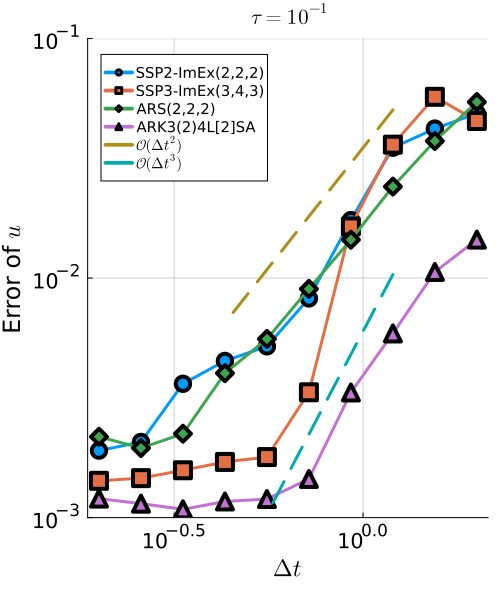

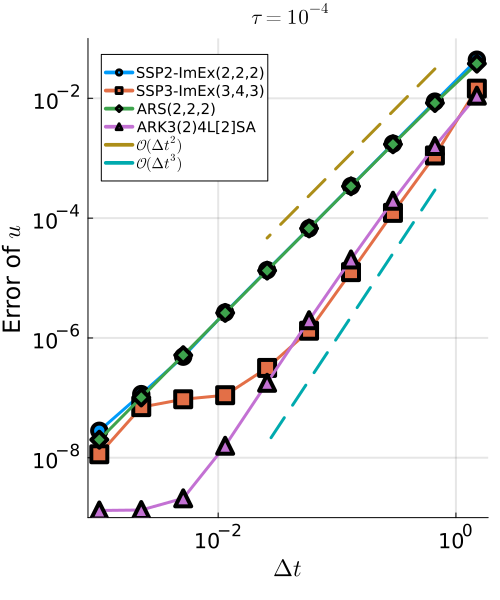

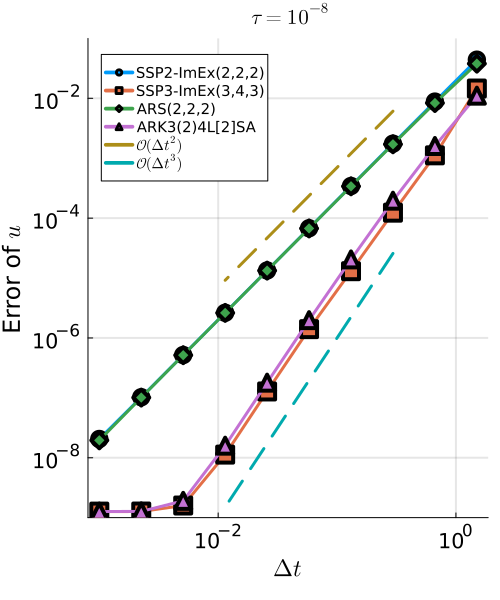

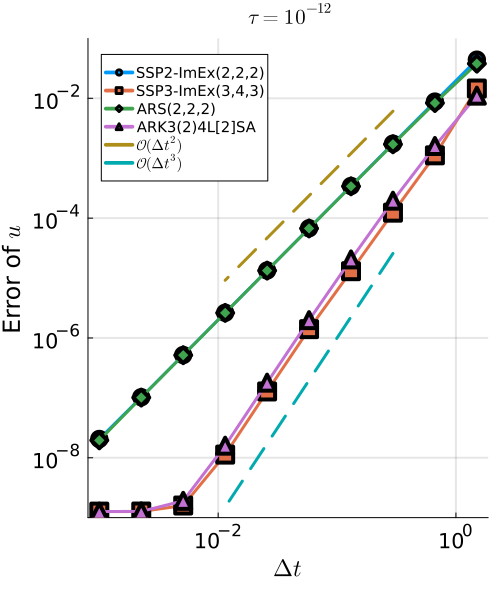

In [ ]:
MthdNames = ["SSP2-ImEx(2,2,2)", "SSP3-ImEx(3,4,3)", "ARS(2,2,2)", "ARK3(2)4L[2]SA"]
# Create the dictionary
MthdDict = Dict(zip(Mthds, MthdNames));
markers = [:circle, :square, :diamond, :utriangle]

# Figure info
yl = [1.0e-3,1.0e-9,1.0e-9,1.0e-9]; yu = [1.0e-1,1.0e-1,1.0e-1,1.0e-1]
P = [2,3]; ST = [3 3; 2 2; 3 3; 3 3]; EN = [7 6; 6 6; 7 7; 7 7]
Fac = [3.5e-2 6.0e-3; 7.0e-2 1.0e-3; 7.0e-2 1.0e-3; 7.0e-2 1.0e-3]

for (i, τ) in enumerate(τs)
    dts = DTs[i,:];
    τ_str = τ == 1.0 ? "\\tau = 1" : "\$\\tau = 10^{-$(Int(-log10(τ)))}\$"
    # Create a new figure for each value of τ
    fig_kdvh_AA = plot(; xguide = L"\Delta t", yguide = L"Error of $u$", title = " $(τ_str)", size = (500, 600), plot_kwargs()...)

    # Loop over methods and plot the error data for each method
    for (j, alg) in enumerate(Mthds)
        plot!(fig_kdvh_AA, dts, errors_data[τ][alg]; label = MthdDict[alg], marker = markers[j], plot_kwargs()...)
    end

    # Add the reference scaling line after plotting the methods' data
    st =
    plot!(fig_kdvh_AA, dts[ST[i,1]:EN[i,1]], Fac[i,1] * dts[ST[i,1]:EN[i,1]].^(P[1]); label = "\$\\mathcal{O}(\\Delta t^{$(P[1])})\$",linestyle=:dash, plot_kwargs()...)
    plot!(fig_kdvh_AA, dts[ST[i,2]:EN[i,2]], Fac[i,2] * dts[ST[i,2]:EN[i,2]].^(P[2]); label = "\$\\mathcal{O}(\\Delta t^{$(P[2])})\$",linestyle=:dash, plot_kwargs()...)

    # Set log scale for both axes and show the legend
    plot!(fig_kdvh_AA; xscale = :log10, yscale = :log10, legend = :topleft, legendfontsize = 10, ylims = (yl[i], yu[i]))

    # Display or save the plot for this value of τ
    display(fig_kdvh_AA)
    # Save the figure
    savefig(fig_kdvh_AA, joinpath(save_path_1, "error_convergence_τ_$(τ).pdf"))
end

In [31]:
tspan

(0.0, 4.800000000000001)

### Error growth plots for different methods, with and without RK relaxation, applied to $\text{KdVH}(\tau)$, with the exact solution computed using the Petviashvili method.

In [ ]:
function kdvh_exact_solitary_wave_error_growth(; domain_traversals = 2,
                                                 τ = 1.0e-2,
                                                 xmin = -40.0,
                                                 xmax = 40.0,
                                                 c = 1.2,
                                                 accuracy_order = 8, N = 2^8,
                                                 alg = ARS443(), dt = 0.01,
                                                 kwargs...)


    # Reference solution by Petviashvili algorithm
    λ = 1/τ; N_ref = 2^10
    x, u0 = petviashvili_kdvh(; xmin = xmin, xmax = xmax, λ = λ, c = c, N = N_ref, maxiter = 1000, tol = 1.0e-12)

    u0itp = LinearInterpolation((x,), u0, extrapolation_bc = Periodic())
    function u_traveling(t, x::Number, equation)
        x_t = mod(x - c * t - xmin, xmax - xmin) + xmin
        u0itp(x_t)
    end
    function u_traveling(t, x::AbstractVector, equation)
        u_traveling.(t, x, equation)
    end



    # Initialization of physical and numerical parameters
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
       derivative_order = 1, accuracy_order,
       xmin, xmax, N)

    # Setup plot
    fig_err = plot(; xguide = L"t", yguide = L"Error of $u$", plot_kwargs()...)

    # Setup callback computing the error
    series_t = Vector{Float64}()
    series_error = Vector{Float64}()
    callback = let series_t = series_t, series_error = series_error
        function (q, parameters, t)
            (; tmp, equation) = parameters

            u = get_u(q, equation)
            u_ref = u_traveling(t, grid(parameters.D1), HyperbolizedKdV(τ))

            @. tmp = u - u_ref
            err = integrate(abs2, tmp, parameters.D1) |> sqrt

            push!(series_t, t)
            push!(series_error, err)
            return nothing
        end
    end


    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(u_traveling, HyperbolizedKdV(τ), tspan, D1)

        @info "Hyperbolized KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        plot!(fig_err, series_t, series_error;
              label = "KdVH($τ), baseline", plot_kwargs()...)

        @info "Hyperbolized KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        plot!(fig_err, series_t, series_error;
              label = "KdVH($τ), relaxation", plot_kwargs()...)
    end
    n = length(series_t)
    st_ind1 = round(Int, 0.05 * n)
    st_ind2 = round(Int, 0.2 * n)

    println("st_ind1 = ", st_ind1)
    println("st_ind2 = ", st_ind2)

    # Use the start index to slice the array from 20% to the end
    plot!(fig_err, series_t[st_ind1:100:end], 1e-3 * series_t[st_ind1:100:end];
          label = L"=\mathcal{O}(t)",linestyle=:dash, plot_kwargs()...)
    plot!(fig_err, series_t[st_ind1:100:st_ind2], 4e-4 * series_t[st_ind1:100:st_ind2].^ 2;
          label = L"=\mathcal{O}(t^2)",linestyle=:dash, plot_kwargs()...)

    plot!(fig_err; xscale = :log10, yscale = :log10, legend = :topleft, plot_kwargs()...)


    return fig_err

end

kdvh_exact_solitary_wave_error_growth (generic function with 1 method)

┌ Info: Converged
│   iter = 55
└   res = 9.983125437429408e-13
[ Info: Hyperbolized KdV without relaxation


  0.486508 seconds (340.10 k allocations: 42.098 MiB, 2.30% gc time, 34.01% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.332155 seconds (106.48 k allocations: 27.188 MiB, 3.17% gc time, 1.56% compilation time)
st_ind1 = 336
st_ind2 = 1343


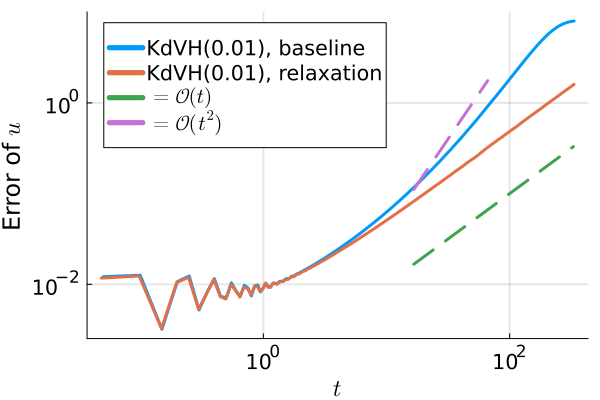

In [33]:
τ = 1.0e-2; xmin = -40.0; xmax = 40.0; c = 1.2; ImEx_name = "SSP2ImEx222"
fig_kdvh_err = kdvh_exact_solitary_wave_error_growth(; domain_traversals = 5,
                                                  τ = τ,
                                                  xmin = xmin,
                                                  xmax = xmax,
                                                  c = c,
                                                  accuracy_order = 8, N = 2^8,
                                                  alg = SSP2ImEx222(), dt = 0.05)

In [ ]:
# Saving the file
using Printf
savefig(fig_kdvh_err, joinpath(save_path_1, "KdVH_Err_growth_" * ImEx_name * "_τ_$(Printf.@sprintf("%.1e", τ))_c_$(Printf.@sprintf("%.1f", c)).pdf"))


"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/KdVH_Err_growth_SSP2ImEx222_τ_1.0e-02_c_1.2.pdf"

┌ Info: Converged
│   iter = 55
└   res = 9.983125437429408e-13
[ Info: Hyperbolized KdV without relaxation


  0.461384 seconds (290.72 k allocations: 38.915 MiB, 1.64% gc time, 29.54% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.342796 seconds (106.58 k allocations: 29.828 MiB, 2.53% gc time, 1.88% compilation time)
st_ind1 = 336
st_ind2 = 1343


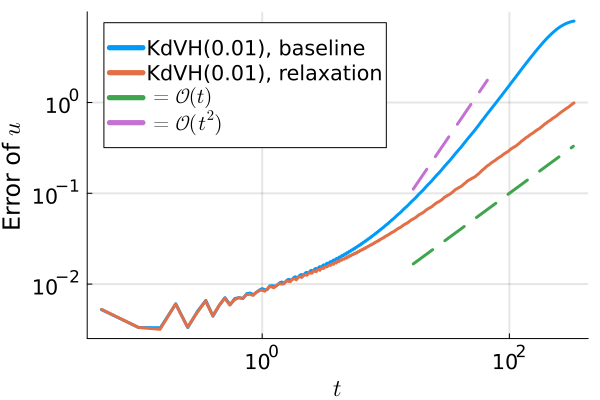

In [35]:
τ = 1.0e-2; xmin = -40.0; xmax = 40.0; c = 1.2; ImEx_name = "ARS222"
fig_kdvh_err = kdvh_exact_solitary_wave_error_growth(; domain_traversals = 5,
                                                  τ = τ,
                                                  xmin = xmin,
                                                  xmax = xmax,
                                                  c = c,
                                                  accuracy_order = 8, N = 2^8,
                                                  alg = ARS222(), dt = 0.05)

In [ ]:
# Saving the file
using Printf
savefig(fig_kdvh_err, joinpath(save_path_1, "KdVH_Err_growth_" * ImEx_name * "_τ_$(Printf.@sprintf("%.1e", τ))_c_$(Printf.@sprintf("%.1f", c)).pdf"))


"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/KdVH_Err_growth_ARS222_τ_1.0e-02_c_1.2.pdf"

### RK relaxation on $\text{KdVH}(\tau)$ to verify linear and quadratic error convergence using conservative versus non-conservative methods.

The error growth of the solutions for the KdV and $\text{KdVH}(\tau)$ systems is analyzed by comparing conservative methods using RK relaxation with non-conservative methods. This approach demonstrates linear error convergence for conservative methods and quadratic error convergence for non-conservative methods. In each case, the numerical solution is compared to the analytical solution of the KdV equation.

In the figure, we will observe:

- Error of the time-stepping method without relaxation for the KdV solution with respect to the KdV analytical solution.
- Error of the time-stepping method with relaxation for the KdV solution with respect to the KdV analytical solution.
- Error of the time-stepping method without relaxation for the KdVH solution (with a particular $\tau$) with respect to the KdV analytical solution.
- Error of the time-stepping method with relaxation for the KdVH solution (with a particular $\tau$) with respect to the KdV analytical solution.

In [37]:
function kdvh_kdv_solitary_wave_error_growth(; τ = 1.0e-4,
                                              domain_traversals = 10,
                                              accuracy_order = 8, N = 2^10,
                                              alg = ARS443(), dt = 0.025,
                                              kwargs...)
    # Initialization of physical and numerical parameters
    (; xmin, xmax, c) = solitary_wave_setup()
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
                          derivative_order = 1, accuracy_order,
                          xmin, xmax, N)
        # This provides the D3 aw well in case of KdV equation,  I checked.

    # Setup plot
    fig_err = plot(; xguide = L"t", yguide = L"Error of $u$", plot_kwargs()...)


    # Setup callback computing the error
    series_t = Vector{Float64}()
    series_error = Vector{Float64}()
    callback = let series_t = series_t, series_error = series_error
        function (q, parameters, t)
            (; tmp, equation) = parameters

            u = get_u(q, equation)
            u_ref = solitary_wave_solution(t, grid(parameters.D1), KdV())

            @. tmp = u - u_ref
            err = integrate(abs2, tmp, parameters.D1) |> sqrt

            push!(series_t, t)
            push!(series_error, err)
            return nothing
        end
    end


    # KdV
    let equation = KdV()
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)

        @info "KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        plot!(fig_err, series_t, series_error;
              label = "KdV, baseline", plot_kwargs()...)

        @info "KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        plot!(fig_err, series_t, series_error;
              label = "KdV, relaxation", plot_kwargs()...)
    end


    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)

        @info "Hyperbolized KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        plot!(fig_err, series_t, series_error;
              label = "KdVH, baseline", plot_kwargs()...)

        @info "Hyperbolized KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        plot!(fig_err, series_t, series_error;
              label = "KdVH, relaxation", plot_kwargs()...)
    end


    plot!(fig_err; xscale = :log10, yscale = :log10, legend = :topleft, plot_kwargs()...)


    return fig_err
end

kdvh_kdv_solitary_wave_error_growth (generic function with 1 method)

[ Info: KdV without relaxation


  0.563972 seconds (229.09 k allocations: 29.876 MiB, 1.83% gc time, 24.34% compilation time)


[ Info: KdV with relaxation


  0.417992 seconds (34.65 k allocations: 17.264 MiB, 1.51% compilation time)


[ Info: Hyperbolized KdV without relaxation


  0.725175 seconds (304.23 k allocations: 40.400 MiB, 1.29% gc time, 19.60% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.587299 seconds (38.81 k allocations: 23.098 MiB, 0.99% compilation time)


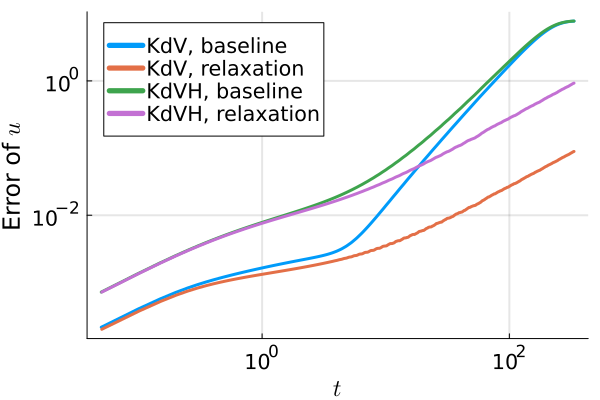

In [38]:
τ = 1.0e-3; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [ ]:
# Saving the file
using Printf
savefig(fig_err, joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(Printf.@sprintf("%.1e", τ)).pdf"))


"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/Err_growth_ARS443_τ_1.0e-03.pdf"

[ Info: KdV without relaxation


  0.412971 seconds (33.66 k allocations: 17.550 MiB)


[ Info: KdV with relaxation


  0.418786 seconds (33.32 k allocations: 17.175 MiB)


[ Info: Hyperbolized KdV without relaxation


  0.584942 seconds (37.82 k allocations: 24.277 MiB, 1.30% gc time)


[ Info: Hyperbolized KdV with relaxation


  0.580552 seconds (37.50 k allocations: 24.141 MiB, 1.16% gc time)


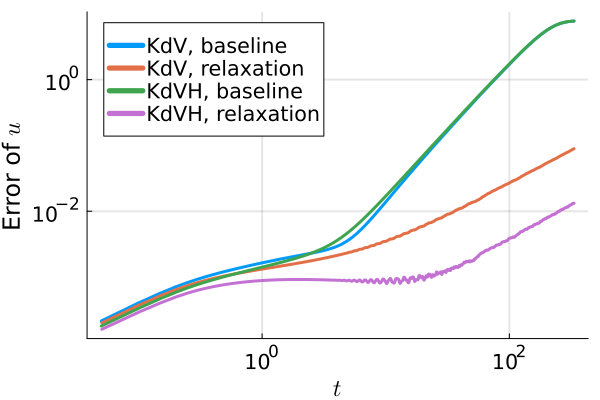

In [40]:
τ = 1.0e-4; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [ ]:
# Saving the file
using Printf
savefig(fig_err, joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(Printf.@sprintf("%.1e", τ)).pdf"))


"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/Err_growth_ARS443_τ_1.0e-04.pdf"

[ Info: KdV without relaxation


  0.415657 seconds (33.66 k allocations: 17.550 MiB)


[ Info: KdV with relaxation


  0.419518 seconds (33.34 k allocations: 17.175 MiB, 1.22% gc time)


[ Info: Hyperbolized KdV without relaxation


  1.172725 seconds (37.81 k allocations: 26.542 MiB)


[ Info: Hyperbolized KdV with relaxation


  1.157856 seconds (37.50 k allocations: 25.272 MiB, 0.28% gc time)


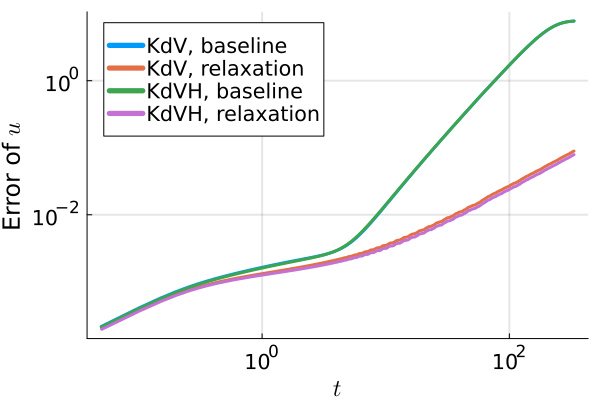

In [42]:
τ = 1.0e-5; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [ ]:
# Saving the file
using Printf
savefig(fig_err, joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(Printf.@sprintf("%.1e", τ)).pdf"))


"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/Err_growth_ARS443_τ_1.0e-05.pdf"

[ Info: KdV without relaxation


  0.417000 seconds (33.66 k allocations: 17.550 MiB, 0.81% gc time)


[ Info: KdV with relaxation


  0.408646 seconds (33.32 k allocations: 17.175 MiB)


[ Info: Hyperbolized KdV without relaxation


  1.171532 seconds (37.82 k allocations: 26.544 MiB, 0.25% gc time)


[ Info: Hyperbolized KdV with relaxation


  1.163080 seconds (37.49 k allocations: 26.407 MiB)


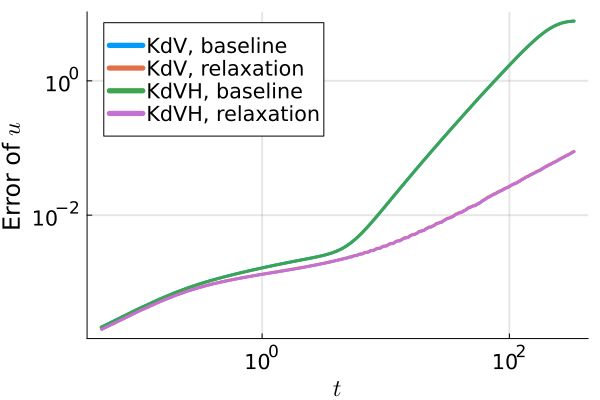

In [44]:
τ = 1.0e-6; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [ ]:
# Saving the file
using Printf
savefig(fig_err, joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(Printf.@sprintf("%.1e", τ)).pdf"))


"/Users/abhijitbiswas/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh/img/Err_growth_ARS443_τ_1.0e-06.pdf"